![](img/330-banner.png)

# Lecture 7: Hyperparameter optimization and optimization bias

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [18]:
import os
import sys

import matplotlib.pyplot as plt
import mglearn

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_colwidth", 200)

## Lecture plan for today

- TBD

<br><br>

## Announcements

- TBD

### Learning outcomes 

From this lecture, you will be able to 

- explain the need for hyperparameter optimization  
- carry out hyperparameter optimization using `sklearn`'s `GridSearchCV` and `RandomizedSearchCV` 
- explain optimization bias
- identify and reason when to trust and not trust reported accuracies 

### Lecture outline

1. [Introduction and motivation](#1)
2. [Hyperparameter optimization](#2)
3. [Optimization bias](#3)
4. [Summary](#4)

## Hyperparameter optimization introduction and motivation 

### Motivation

- Remember that the fundamental goal of supervised machine is to generalize beyond what we see in the training examples. 
- We have been using data splitting and cross-validation to provide a framework to approximate generalization error.  
- With this framework, we can improve the model's generalization performance by tuning model hyperparameters using cross-validation on the training set. 

In homework assignments, we have been carrying out hyperparameter search by exhaustively trying all possible combinations of the hyperparameters of interest. 

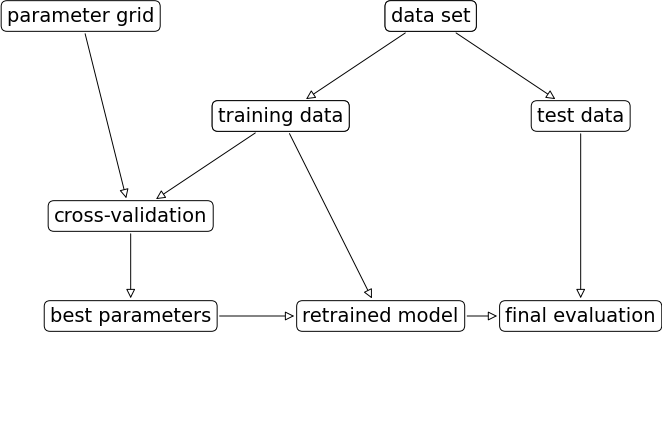

In [3]:
mglearn.plots.plot_grid_search_overview()

Let's look at an example of training SVM RBF classifier on the Spotify dataset. 

In [37]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "song_title", "artist"])
print("The number of features in the Spotify dataset: %d" % X_spotify.shape[1])
X_spotify.head()

The number of features in the Spotify dataset: 13


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


In [38]:
y_spotify = spotify_df["target"]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spotify, y_spotify, test_size=0.2, random_state=123
)

In [92]:
pipe_svm = make_pipeline(StandardScaler(), SVC())
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

Let's try cross-validation with default hyperparameters of SVC. 

In [93]:
scores = cross_validate(pipe_svm, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.047906
score_time     0.024358
test_score     0.738998
train_score    0.814011
dtype: float64

Now let's try exhaustive hyperparameter search using for loops. 

In [82]:
best_score = 0

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}

results_dict = {"C": [], "gamma": [], "mean_cv_score": []}

for gamma in param_grid["gamma"]:
    for C in param_grid["C"]:  # for each combination of parameters, train an SVC
        pipe_svm = make_pipeline(StandardScaler(), SVC(gamma=gamma, C=C))
        scores = cross_val_score(pipe_svm, X_train, y_train)  # perform cross-validation
        mean_score = np.mean(scores)  # compute mean cross-validation accuracy
        if (
            mean_score > best_score
        ):  # if we got a better score, store the score and parameters
            best_score = mean_score
            best_parameters = {"C": C, "gamma": gamma}
        results_dict["C"].append(C)
        results_dict["gamma"].append(gamma)
        results_dict["mean_cv_score"].append(mean_score)

In [83]:
best_parameters

{'C': 1, 'gamma': 0.1}

In [84]:
best_score

0.7439609253312309

In [85]:
df = pd.DataFrame(search_dict)

In [86]:
df.sort_values(by="mean_cv_score", ascending=False)

,C,gamma,mean_cv_score
15,1.000,0.100,0.743961
11,100.000,0.010,0.732792
16,10.000,0.100,0.729091
10,10.000,0.010,0.720391
17,100.000,0.100,0.711715
5,100.000,0.001,0.704284
14,0.100,0.100,0.703034
9,1.000,0.010,0.697473
8,0.100,0.010,0.678851
4,10.000,0.001,0.678244


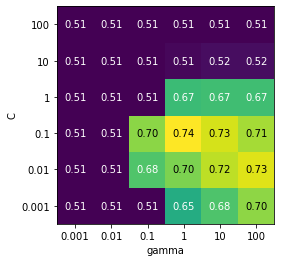

In [89]:
scores = np.array(df.mean_cv_score).reshape(6, 6)

mglearn.tools.heatmap(
    scores,
    xlabel="gamma",
    xticklabels=param_grid["gamma"],
    ylabel="C",
    yticklabels=param_grid["C"],
    cmap="viridis",
)
# plot the mean cross-validation scores

- We have 6 possible values for `C` and 6 possible values for `gamma`. 
- In 5-fold cross-validation, for each combination of parameter values, five accuracies are computed.
- So to evaluate the accuracy of the SVM using 6 values of C and 6 values of gamma using five-fold cross-validation, we need to train 36 * 5 = 180 models! 

Once we have optimized hyperparameters, we retrain a model on the full training set with these optimized hyperparameters. 

In [65]:
pipe_svm = make_pipeline(StandardScaler(), SVC(**best_parameters))
pipe_svm.fit(
    X_train, y_train
)  # Retrain a model with optimized hyperparameters on the combined training and validation set

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, gamma=0.1))])

And finally evaluate the performance of this model on the test set. 

In [67]:
pipe_svm.score(X_test, y_test)  # Final evaluation on the test data

0.7376237623762376

This is a very common process in supervised machine learning pipelines and there are some standard method in `scikit-learn` to help with this.  

### Hyperparameters: the problem

- In order to get the best generalization performance, finding the best values for the important hyperparameters of a model is necessary for almost all models and datasets. 
- Picking reasonable hyperparameters is important because if we don't do it, we might end up with an underfit or overfit model. 
- The problem of finding the best values for the important hyperparameters is tricky because 
    - You may have a lot of them (e.g. deep learning). 
    - You may have multiple hyperparameters which may interact with each other in unexpected ways.    
- The best settings depend on the specific data/problem.

### Some ways to pick hyperparameters:
- Manual or expert knowledge or heuristics based optimization 
- Data-driven or automated optimization (this lecture)

#### Manual hyperparameter optimization

- Advantage: we may have some intuition about what might work.
  - E.g. if I'm massively overfitting, try decreasing `max_depth` or `C`.
- Disadvantage: it takes a lot of work.
- Disadvantage: in very complicated cases, our intuition might be worse than a data-driven approach.

#### Automated hyperparameter optimization

- Advantages 
    - reduce human effort
    - less prone to error and improve reproducibility
    - data-driven approaches may be effective
- Disadvantages
    - may be hard to incorporate intuition
    - be careful about overfitting on the validation set.

<br><br><br><br>

## Hyperparameter optimization with `scikit-learn`
There are two automated hyperparameter search methods in `scikit-learn`:

- Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- Randomized hyperparameter optimization: [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  
The "CV" stands for cross-validation; these methods have cross-validation built right in.

### Dataset

We'll use the [IMDB movie review](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset

In [6]:
imdb_df = pd.read_csv("data/imdb_master.csv", encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df["label"].str.startswith(("pos", "neg"))]
imdb_df.drop(["Unnamed: 0", "type", "file"], axis=1, inplace=True)
imdb_df.head()

,review,label
0,"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the charact...",neg
1,"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and...",neg
2,"First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like clichÃ©'e version of gangst...",neg
3,"Not even the Beatles could write songs everyone liked, and although Walter Hill is no mop-top he's second to none when it comes to thought provoking action movies. The nineties came and social pla...",neg
4,Brass pictures (movies is not a fitting word for them) really are somewhat brassy. Their alluring visual qualities are reminiscent of expensive high class TV commercials. But unfortunately Brass p...,neg


In [7]:
import re


def replace_tags(doc):
    doc = doc.replace("<br />", " ")
    doc = re.sub("https://\S*", "", doc)
    return doc

In [17]:
imdb_df["review_pp"] = imdb_df["review"].apply(replace_tags)

In [30]:
train_df, test_df = train_test_split(imdb_df, test_size=0.9, random_state=123)
X_train, y_train = train_df["review_pp"], train_df["label"]
X_test, y_test = test_df["review_pp"], test_df["label"]
train_df.shape

(5000, 3)

In [36]:
vec = CountVectorizer(stop_words="english", max_features=5000)
X_train_imdb = vec.fit_transform(X_train)
X_test_imdb = vec.transform(X_test)

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### Exhaustive grid search

- A user specifies a set of values for each hyperparameter. 
- The method considers "product" of the sets and then evaluates each combination one by one.    

Let's start the automated hyperparameter optimization.

In [33]:
param_grid = {"C": [0.01, 1, 10, 100]}

In [40]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, verbose=1)

- Note that we can fix some hyperparameters and make others variable.
- `verbose=1` tells `GridSearchCV` to print some output while it's working.
  - This can be useful as this step sometimes takes a long time.

In [41]:
grid_search.fit(X_train_imdb, y_train);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Going back to Lecture 3, this is what it's doing:

```
for C in [0.01, 1, 10, 100]:
    for fold in folds:
        fit in training portion with the given C
        score on validation portion
    compute average score
pick hypers with best score
```

From here, we can extract the best hyperparameter values:

In [27]:
grid_search.best_params_

{'C': 0.01}

In [28]:
grid_search.best_score_

0.8474666666666668

We can extract the classifier inside like this:

In [29]:
grid_search.best_estimator_

LogisticRegression(C=0.01, max_iter=1000)

In [30]:
grid_search.best_estimator_.predict(X_test_imdb)

array(['pos', 'pos', 'pos', ..., 'pos', 'pos', 'pos'], dtype=object)

They also provide some "syntactic sugar" and allow you to call `predict` or `score` directly on the `GridSearchCV` object:

In [31]:
grid_search.predict(X_test_imdb)  ## Does the same thing

array(['pos', 'pos', 'pos', ..., 'pos', 'pos', 'pos'], dtype=object)

By the way, by default it takes the best hyperparameters and refits on the entire training set - very nice!

In [33]:
# ?GridSearchCV

Note the `refit=True` to control this.

- Ok, so this is all the syntax, but now we know we've been violating the Golden Rule because of the cross-validation.
- Furthermore, we may want to tune the hyperparameters of the `CountVectorizer` and the `LogisticRegression` together.
- Pipelines are perfect for this!!
- So let's do it again properly this time.

In [38]:
countvec = CountVectorizer(
    binary=True
)  # we should not set min_df here, it will be optimized
lr = LogisticRegression(max_iter=1000)  # we should not set C here, it will be optimized

pipe = Pipeline([("countvec", countvec), ("lr", lr)])

In [39]:
param_grid = {"countvec__min_df": [0, 10, 100], "lr__C": [0.01, 1, 10, 100]}

- Above: we have a nesting of transformers. 
- We can access the parameters of the "inner" objects by using `__` to go "deeper":
  - `countvec__min_df`: "the `min_df` of the `CountVectorizer` (of the pipeline)"
  - `lr__C`: "the `C` of the `LogisticRegression` (of the pipeline)"
- Later in the course we'll see even deeper nesting, like `preprocessor__numeric__imputer__strategy`.

So, now we pass int he `Pipeline` to `GridSearchCV`:

In [40]:
grid_search = GridSearchCV(pipe, param_grid, verbose=2, n_jobs=-1)

And we pass in the raw text because we're using a `Pipeline`:

In [41]:
grid_search.fit(X_train_imdb_raw, y_train_imdb);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   44.0s finished


- Note the `n_jobs=-1` above.
- Hyperparameter optimization can be done _in parallel_ for each of the configurations.
- This is very useful when scaling up to large numbers of machines in the cloud.
- But even on my laptop there are 8 cores it can use, so that makes it a lot faster.

In [42]:
grid_search.best_params_

{'countvec__min_df': 0, 'lr__C': 1}

Heh, here we get back the defaults again. This happens surprisingly often - the defaults are well chosen!

- Note the number of candidates comes from the **product** of the number of options for each hyperparameter.
- And then the whole thing multiplied by the number of folds (default is 5).
- So, this number can get big really fast.

But note that we're searching more possibilities than if we just sweep one hyperparameter at a time:

![](img/gridsearch.png)

In that case we'd only get the ones in red, but here we get the entire grid.

(Img source: see credit below)

#### Problems with exhaustive grid search 

- Required number of models to evaluate grows exponentially with the dimensionally of the configuration space. 
- Exhaustive search may become infeasible fairly quickly. 

## Data 

We'll be using [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#) you used in lab 2. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The code below loads the data CSV (assuming that it is saved as `data/adult.csv` in this folder). 

*Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary.*

### Reading the data CSV and splitting it

In [2]:
adult_df_large = pd.read_csv("data/adult.csv")
adult_df_sample = adult_df_large.sample(frac=0.3)

In [3]:
train_df, test_df = train_test_split(adult_df_sample, test_size=0.2, random_state=42)

In [4]:
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)

In [5]:
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
19258,23,Private,237044,HS-grad,9,Never-married,Other-service,Own-child,Black,Male,0,0,12,United-States,<=50K
9782,35,Private,38948,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
1842,46,Private,155659,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,15024,0,45,United-States,>50K
29224,42,Private,126003,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,>50K
16985,38,Self-emp-not-inc,114835,Bachelors,13,Married-civ-spouse,Sales,Wife,White,Female,0,0,60,United-States,>50K


In [6]:
train_df_nan["income"].value_counts()

<=50K    5914
>50K     1900
Name: income, dtype: int64

### Identify feature types

In [7]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
# I am removing eduction.num column
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "sex",
    "native.country",
]
# I am removing 'race' column
ordinal_features = ["education"]
target = "income"

In [8]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [9]:
assert set(education_levels) == set(train_df["education"].unique())

In [10]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

### Define `ColumnTransformer` and a pipeline 

In [11]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(
        categories=[education_levels],
        dtype=int,
    ),
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ordinal", ordinal_transformer, ordinal_features),
    ]
)
pipe = make_pipeline(preprocessor, SVC())

In [12]:
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)

In [13]:
pd.DataFrame(scores).mean()

fit_time       0.619898
score_time     0.113588
test_score     0.846430
train_score    0.848861
dtype: float64

- We are using the default hyperparameters for SVC. 
- We have cherry picked hyperparameters for some of our transformers.  
- Probably we could do better with different hyperparameters. 

### Let's carry out hyperparameter optimization with `C` and `gamma`

In [14]:
### Writing a loop for hyperparameter optimization for gamma and C for SVC
param_grid = {"gamma": [0.1, 1.0, 10, 100], "C": [0.1, 1.0, 10, 100]}

param_scores = {"gamma": [], "C": [], "train_accuracy": [], "valid_accuracy": []}
for gamma_val in param_grid["gamma"]:
    for c_val in param_grid["C"]:
        pipe = make_pipeline(preprocessor, SVC(gamma=gamma_val, C=c_val))
        scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
        param_scores["gamma"].append(gamma_val)
        param_scores["C"].append(c_val)
        param_scores["train_accuracy"].append(np.mean(scores["train_score"]))
        param_scores["valid_accuracy"].append(np.mean(scores["test_score"]))

In [15]:
pd.DataFrame(param_scores).sort_values("valid_accuracy", ascending=False)

,gamma,C,train_accuracy,valid_accuracy
1,0.1,1.0,0.872728,0.852444
2,0.1,10.0,0.916048,0.845406
0,0.1,0.1,0.839615,0.832480
3,0.1,100.0,0.949898,0.810981
5,1.0,1.0,0.957384,0.791401
6,1.0,10.0,0.984419,0.783593
7,1.0,100.0,0.994081,0.778601
4,1.0,0.1,0.765357,0.763117
9,10.0,1.0,0.989890,0.758766
10,10.0,10.0,0.998432,0.757999


### Questions and comments 

- How many 5-fold cross-validation experiments are carried out here? 
- How would it work with more hyperparameters? 
- Remember that we also have hyperparameters of our transformers. For example, you might want to try "mean" or "median" strategies for your scaler and pick the one that works best. 
- If you want to try multiple classifiers each with a different set of hyperparameters
- Writing for loops for this and keeping track of all scores becomes unwieldy quite quickly! 

### Automated hyperparameter tuning: the solution?

- Advantage: reduce human effort
- Advantage: less prone to error and improve reproducibility
- Advantage: data-driven approaches may be effective
- Disadvantage: may be hard to incorporate intuition
- Disadvantage: be careful about overfitting on the validation set (We'll talk about it in the second part.)


### `scikit-learn` built-in methods for hyperparameter optimization

`scikit-learn` has the following [built-in methods](https://scikit-learn.org/stable/modules/grid_search.html) which automate hyperparameter optimization for you. 

1. Exhaustive grid search 
    - [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
2. Randomized hyperparameter optimization 
    - [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### Exhaustive grid search

- [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

- How does it work? 
    - A user specifies a set of values for each hyperparameter. 
    - The method considers product of the sets and then evaluates each combination one by one.    

In [16]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "svc__gamma": [0.1, 1.0, 10, 100],
    "svc__C": [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train);

CPU times: user 1.59 s, sys: 229 ms, total: 1.82 s
Wall time: 31.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'capital.gain',
                                                                          'capital.loss',
                                            

In [17]:
print("Best cv score from grid search: %.3f" % grid_search.best_score_)
grid_search.best_params_

Best cv score from grid search: 0.852


{'svc__C': 1.0, 'svc__gamma': 0.1}

In [18]:
pd.DataFrame(grid_search.cv_results_).set_index("rank_test_score").sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,...,split4_test_score,mean_test_score,std_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,1.908747,0.016357,0.204031,0.003334,1,0.1,"{'svc__C': 1.0, 'svc__gamma': 0.1}",0.842610,0.859245,0.859885,...,0.851472,0.852444,0.006497,0.874740,0.872820,0.870261,0.874420,0.871401,0.872728,0.001719
2,2.748669,0.037835,0.195921,0.002304,10,0.1,"{'svc__C': 10, 'svc__gamma': 0.1}",0.840051,0.854766,0.849008,...,0.845711,0.845406,0.006197,0.918733,0.913614,0.914894,0.916493,0.916507,0.916048,0.001725
3,2.926996,0.059028,0.265295,0.013773,0.1,0.1,"{'svc__C': 0.1, 'svc__gamma': 0.1}",0.820857,0.834933,0.843890,...,0.834187,0.832480,0.007613,0.844345,0.837946,0.836826,0.838746,0.840211,0.839615,0.002609
4,4.166481,0.121645,0.194305,0.005071,100,0.1,"{'svc__C': 100, 'svc__gamma': 0.1}",0.815099,0.818938,0.813820,...,0.816261,0.810981,0.010237,0.950088,0.948808,0.948488,0.952488,0.949616,0.949898,0.001414
5,5.088506,0.147284,0.441413,0.010283,1,1,"{'svc__C': 1.0, 'svc__gamma': 1.0}",0.789507,0.796545,0.804862,...,0.797695,0.791401,0.012492,0.957287,0.957447,0.956327,0.958727,0.957134,0.957384,0.000774
6,5.591746,0.553660,0.551825,0.058971,10,1,"{'svc__C': 10, 'svc__gamma': 1.0}",0.777351,0.795905,0.792706,...,0.775928,0.783593,0.008820,0.984163,0.983843,0.984642,0.984482,0.984965,0.984419,0.000387
7,5.143064,0.519868,0.353574,0.008612,100,1,"{'svc__C': 100, 'svc__gamma': 1.0}",0.773512,0.798464,0.780550,...,0.765045,0.778601,0.011118,0.993921,0.993121,0.994561,0.994561,0.994242,0.994081,0.000535
8,5.105062,0.200283,0.591333,0.052098,0.1,1,"{'svc__C': 0.1, 'svc__gamma': 1.0}",0.763916,0.762636,0.764555,...,0.762484,0.763117,0.000959,0.766597,0.765318,0.763718,0.765797,0.765355,0.765357,0.000940
9,5.050587,0.091293,0.584451,0.032579,1,10,"{'svc__C': 1.0, 'svc__gamma': 10}",0.760717,0.756878,0.760077,...,0.758003,0.758766,0.001417,0.989922,0.989122,0.990082,0.989282,0.991043,0.989890,0.000682


### The `__` syntax 

- Above: we have a nesting of transformers.
- We can access the parameters of the "inner" objects by using __ to go "deeper":
- `svc__gamma`: the `gamma` of the `svc` of the pipeline
- `svc__C`: the `C` of the `svc` of the pipeline

### How do we access hyperparameters of transformers

- `columntransformer__num__simpleimputer__strategy`: the strategy used with `SimpleImputer` of the preprocessor in the pipeline. 
Later in the course we'll see even deeper nesting, like preprocessor__numeric__imputer__strategy.


In [19]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                             

In [20]:
param_grid = {
    "svc__gamma": [0.1, 1.0],
    "columntransformer__num__simpleimputer__strategy": ["mean", "median"],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train);

In [21]:
print(("Best SVC from grid search: %.3f" % grid_search.score(X_test, y_test)))
grid_search.best_params_
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")

Best SVC from grid search: 0.814


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__num__simpleimputer__strategy,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.369722,0.073645,0.187483,0.002374,mean,0.1,"{'columntransformer__num__simpleimputer__strategy': 'mean', 'svc__gamma': 0.1}",0.815099,0.818938,0.81382,...,0.810981,0.010237,1,0.950088,0.948808,0.948488,0.952488,0.949616,0.949898,0.001414
2,4.416549,0.066688,0.186616,0.001750,median,0.1,"{'columntransformer__num__simpleimputer__strategy': 'median', 'svc__gamma': 0.1}",0.815099,0.818938,0.81382,...,0.810981,0.010237,1,0.950088,0.948808,0.948488,0.952488,0.949616,0.949898,0.001414
1,5.850827,0.385002,0.276416,0.006900,mean,1,"{'columntransformer__num__simpleimputer__strategy': 'mean', 'svc__gamma': 1.0}",0.773512,0.798464,0.78055,...,0.778601,0.011118,3,0.993921,0.993121,0.994561,0.994561,0.994242,0.994081,0.000535
3,5.791268,0.403897,0.277448,0.007326,median,1,"{'columntransformer__num__simpleimputer__strategy': 'median', 'svc__gamma': 1.0}",0.773512,0.798464,0.78055,...,0.778601,0.011118,3,0.993921,0.993121,0.994561,0.994561,0.994242,0.994081,0.000535


In [22]:
pd.DataFrame(grid_search.cv_results_)[
    [
        "mean_test_score",
        "param_columntransformer__num__simpleimputer__strategy",
        "param_svc__gamma",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

,mean_test_score,param_columntransformer__num__simpleimputer__strategy,param_svc__gamma,mean_fit_time
rank_test_score,,,,
1,0.810981,mean,0.1,4.369722
1,0.810981,median,0.1,4.416549
3,0.778601,mean,1,5.850827
3,0.778601,median,1,5.791268


In [23]:
# How many combinations in total?
np.prod(list(map(len, param_grid.values())))

4

### Problems with exhaustive grid search 

- Required number of models to evaluate grows exponentially with the dimensionally of the configuration space. 
- Example: Suppose you have
    - 5 hyperparameters 
    - 10 different values for each hyperparameter
    - You'll be evaluating $10^5=100,000$ models! That is you'll be calling `cross_validate` 100,000 times!
- Exhaustive search may become infeasible fairly quickly. 
- Other options? 


### Randomized hyperparameter search

- Randomized hyperparameter optimization 
    - [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Samples configurations at random until certain budget (e.g., time) is exhausted 

In [26]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "svc__gamma": 10.0 ** np.arange(-6, 6),
    "svc__C": 10.0 ** np.arange(-6, 6),
}
print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 144


{'svc__gamma': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 'svc__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02, 1.e+03, 1.e+04, 1.e+05])}

In [27]:
random_search = RandomizedSearchCV(
    pipe, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=5
)
random_search.fit(X_train, y_train);

In [33]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

,mean_test_score,param_svc__gamma,param_svc__C,mean_fit_time
rank_test_score,,,,
1,0.853852,0.01,10,0.612439
2,0.849118,0.0001,10000,1.088907
3,0.845406,0.1,10,0.887579
4,0.783593,1,10,2.034650
5,0.778473,1,100000,7.923222
6,0.757743,10,10000,1.819518
7,0.756847,10000,1e-06,0.651702
7,0.756847,1e-05,0.01,0.710953
7,0.756847,100000,0.01,1.337574



### Advantages of `RandomizedSearchCV`

- Faster compared to `GridSearchCV`.
- Adding parameters that do not influence the performance does not affect efficiency.
- In general, I recommend using `RandomizedSearchCV` rather than `GridSearchCV`.    

### Advantages of `RandomizedSearchCV`

- Works better when some parameters are more important than others. 

![](images/randomsearch_bergstra.png)

Source: [Bergstra and Bengio, Random Search for Hyper-Parameter Optimization, JMLR 2012](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).
- The yellow on the left shows how your scores are going to change when you vary the unimportant hyperparameter.
- The green on the top shows how your scores are  going to change when you vary the important hyperparameter.
- You don't know in advance which hyperparameters are important for your problem.
- In the left figure, 6 of the 9 searches are useless because they are only varying the unimportant parameter.
- In the right figure, all 9 searches are useful.

## Fancier methods (optional)
- Both `GridSearchCV` and `RandomizedSearchCV` do each trial independently.
- What if you could learn from your experience, e.g. learn that `max_depth=3` is bad?
  - That could save time because you wouldn't try combinations involving `max_depth=3` in the future.
- We can do this with `scikit-optimize`, which is a completely different package from `scikit-learn`
- It uses a technique called "model-based optimization" and we'll specifically use "Bayesian optimization".
  - In short, it uses machine learning to predict what hyperparameters will be good.
  - Machine learning on machine learning!
- This is an active research area and there are sophisticated packages for this. 
- It was Mike's [PhD thesis](https://dash.harvard.edu/bitstream/handle/1/17467236/GELBART-DISSERTATION-2015.pdf?sequence=4) topic. So you can bother him if want to know more about it :). 

- If you want to run the following optional code, you'll have to install `scikit-optimize`

`conda install -c conda-forge scikit-optimize`

- `BayesSearchCV` uses the same interface as `GridSearchCV` and `RandomSearchCV`.
- However, the way we specify the parameter distributions is slightly different.
- Here, we can just give the bounds as tuples.

In [28]:
from skopt import BayesSearchCV

In [29]:
pipe = make_pipeline(preprocessor, SVC())

bayes_opt = BayesSearchCV(
    pipe,
    {
        "svc__C": (0.1, 10),
        "columntransformer__num__simpleimputer__strategy": ("mean", "median"),
    },
    n_iter=10,
    cv=5,
    random_state=123,
    verbose=0,
    refit=True,
)

In [30]:
bayes_opt.fit(X_train, y_train);

- It took a similar amount of time to the other methods.
- In reality there is some extra computation to do the "meta-ML".
- However, the overall time is dominated by the time of calling `fit` on the `SVC`.

In [31]:
bayes_opt.best_params_

OrderedDict([('columntransformer__num__simpleimputer__strategy', 'mean'),
             ('svc__C', 9.901973022704464)])

In [32]:
bayes_opt.best_score_

0.8523163552597901

#### Pros and cons of BayesOpt

- Advantage: can find better hyperparameter values with fewer trials.
- Disadvantage: requires installation.
- Disadvantage: when number of trials is large (e.g. hundreds), the meta-ML can actually get too slow.
- Disadvantage: harder to parallelize the search because each trial depends on the previous ones.
  - Note `n_jobs` parameter for `GridSearchCV` and `RandomizedSearchCV`.  
  - `BayesSearchCV` also has this parameter.
  - It can definitely parallelize the folds.
  - The search will be less effective if it parallelizes further.

### Questions for class discussion (hyperparameter optimization)

- Suppose you have 10 hyperparameters, each with 4 possible values. If you run `GridSearchCV` with this parameter grid, how many cross-validation experiments it would carry out? 
- `GridSearchCV` exhaustively searches the grid and so it's guaranteed to give you the optimal hyperparameters for the given problem. 
- It is possible to get different hyperparameters in different runs of `RandomizedSearchCV`.
- Suppose you have 10 hyperparameters and each takes 4 values. If you run `RandomizedSearchCV` with this parameter grid, how many cross-validation experiments it would carry out? 


## 3. Optimization bias <a name="3"></a>

### Overfitting of the validation error 

- Why do we need to evaluate the model on the test set in the end?
- Why not just use cross-validation on the whole dataset? 
- While carrying out hyperparameter optimization, we end up trying over many possibilities.  
- If our dataset is small and if your validation set is hit too many times, we suffer from **optimization bias** or **overfitting the validation set**. 

### Overfitting of the validation error 

Optimization bias of parameter learning:
- During learning, we could search over tons of different decision trees.
- So we can get "lucky" and find one with low training error by chance.
    - "Overfitting of the training error".
    
Optimization bias of hyper-parameter learning:
- Here, we might optimize the validation error over 100 values of `max_depth`.
- One of the 100 trees might have low validation error by chance.

### Example 1: Optimization bias (optional)

Consider a multiple-choice (a,b,c,d) "test" with 10 questions:
- If you choose answers randomly, expected grade is 25% (no bias).
- If you fill out two tests randomly and pick the best, expected grade is 33%.
    - Optimization bias of ~8%.
- If you take the best among 10 random tests, expected grade is ~47%.
- If you take the best among 100, expected grade is ~62%.
- If you take the best among 1000, expected grade is ~73%.
- If you take the best among 10000, expected grade is ~82%.
    - You have so many "chances" that you expect to do well.
    
**But on new questions the "random choice" accuracy is still 25%.**

In [ ]:
# Code attribution: Thanks to Rodolfo! (optional)
number_tests = [1, 2, 10, 100, 1000, 10000]
for ntests in number_tests:
    y = np.zeros(10000)
    for i in range(10000):
        y[i] = np.max(np.random.binomial(10.0, 0.25, ntests))
    print(
        "The expected grade among the best of %d tests is : %0.2f"
        % (ntests, np.mean(y) / 10.0)
    )

### Example 2: Optimization bias (optional)

- If we instead used a 100-question test then:
    - Expected grade from best over 1 randomly-filled test is 25%.
    - Expected grade from best over 2 randomly-filled test is ~27%.
    - Expected grade from best over 10 randomly-filled test is ~32%.
    - Expected grade from best over 100 randomly-filled test is ~36%.
    - Expected grade from best over 1000 randomly-filled test is ~40%.
    - Expected grade from best over 10000 randomly-filled test is ~43%.

- The optimization bias **grows with the number of things we try**.
    - “Complexity” of the set of models we search over.
- But, optimization bias **shrinks quickly with the number of examples**.
    - But it’s still non-zero and growing if you over-use your validation set!    

In [ ]:
# Code attribution: Thanks to Rodolfo! (optional)
number_tests = [1, 2, 10, 100, 1000, 10000]
for ntests in number_tests:
    y = np.zeros(10000)
    for i in range(10000):
        y[i] = np.max(np.random.binomial(100.0, 0.25, ntests))
    print(
        "The expected grade among the best of %d tests is : %0.2f"
        % (ntests, np.mean(y) / 100.0)
    )

### Let's examine effects of optimization on the adult income dataset

In [34]:
train_df, test_df = train_test_split(adult_df_large, test_size=0.99, random_state=42)

In [57]:
train_df.shape

(325, 15)

In [35]:
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)

In [36]:
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
15087,34,Private,119153,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,<=50K
11774,22,Private,215477,Some-college,10,Never-married,Transport-moving,Own-child,White,Male,0,0,40,United-States,<=50K
1930,30,Local-gov,182926,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,15024,0,40,United-States,>50K
23509,33,Private,124052,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
197,49,Local-gov,102359,9th,5,Widowed,Handlers-cleaners,Unmarried,White,Male,0,2231,40,United-States,>50K


In [37]:
train_df_nan["income"].value_counts()

<=50K    246
>50K      79
Name: income, dtype: int64

### Identify feature types

In [38]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
# I am removing eduction.num column
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "sex",
    "native.country",
]
# I am removing 'race' column
ordinal_features = ["education"]
target = "income"

In [39]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [42]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

### Define `ColumnTransformer` and a pipeline 

In [43]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(
        categories=[education_levels],
        dtype=int,
    ),
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ordinal", ordinal_transformer, ordinal_features),
    ]
)
pipe = make_pipeline(preprocessor, SVC())

In [52]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "svc__gamma": 10.0 ** np.arange(-20, 10),
    "svc__C": 10.0 ** np.arange(-20, 10),
}
print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 900


{'svc__gamma': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
        1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09]),
 'svc__C': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
        1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])}

In [54]:
random_search = RandomizedSearchCV(
    pipe, param_distributions=param_grid, n_jobs=-1, n_iter=900, cv=5
)
random_search.fit(X_train, y_train);

In [58]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head(5)

,mean_test_score,param_svc__gamma,param_svc__C,mean_fit_time
rank_test_score,,,,
1,0.852308,0.001,1000,0.025669
1,0.852308,0.1,1,0.024438
3,0.846154,0.01,10,0.027776
3,0.846154,1e-05,1e+07,0.204596
5,0.843077,1e-08,1e+08,0.021219


- Do we really believe that 0.85 is a good estimate of our test data?
- Do we really believe that `gamma`=0.001 and C=1000 are the best hyperparameters? 

- No, because our training data is quite small and so our validation splits in cross validation would be small. 
- No, because of the small dataset and the fact that we hit the small validation set 900 times and it's possible that we got lucky on the validation set! 
- Let's find out the test score with this best model. 

In [59]:
random_search.score(X_test, y_test)

0.8083198908053109

- We can trust this test score because it's a huge test set.

### Overfitting of the validation data

<center>
<img src='./images/optimization-bias.png' width="800">
</center>


[Source](https://amueller.github.io/COMS4995-s20/slides/aml-03-supervised-learning/#20)

- Thus, not only can we not trust the cv scores, we also cannot trust cv's ability to choose of the best hyperparameters. 


### Why do we need a test set? 
- We have a VERY optimistic cross-validation score.
- This is why we need a test set.
- The frustrating part is that if our dataset is small then our test set is also small :(. 
- But we don't have a lot of better alternatives, unfortunately, if we have a small dataset. 

### Large datasets solves many of these problems
- With infinite amounts of training data, overfitting would not be a problem and you could have your test score = your train score.
    - Overfitting happens because you only see a bit of data and you learn patterns that are overly specific to your sample.
    - If you saw "all" the data, then the notion of "overly specific" would not apply.
- So, more data will make your test score better and robust. 
- What to do if your test score is much lower than your cross-validation score:
    - Try simpler models and use the test set a couple of times - it's not the end of the world.
    - Communicate this clearly when you report the results. 

### Questions for class discussion (optimization bias)

### Would you trust the model?  

- You have a dataset and you give me half of it. I build a model using all the data you have given me and I tell you that the model accuracy is 0.99. Would it classify the rest of the data with similar accuracy? 

1. Probably 
2. Probably not 

### Would you trust the model?  

- You have a dataset and you give me half of it. I build a model using 80% of the data given to me and report the accuracy of 0.95 on the remaining 20% of the data. Would it classify the rest of the data with similar accuracy? 

1. Probably 
2. Probably not 

### Would you trust the model?  

- You have a dataset and you give me 1/10th of it. The dataset given to me is rather small and so I split it into 96% train and 4% validation split. I carry out hyperparameter optimization using a single 4% validation split and report validation accuracy of 0.97. Would it classify the rest of the data with similar accuracy? 

1. Probably 
2. Probably not 

## Optional readings and resources

- [Preventing "overfitting" of cross-validation data](http://www.robotics.stanford.edu/~ang/papers/cv-final.pdf) by Andrew Ng